In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from truesight.core import TrueSight
from truesight.preprocessing import Preprocessor

In [ ]:
df = pd.read_csv(f"datasets\M5\sales_train_evaluation.csv")
df.drop(["item_id", "dept_id", "cat_id", "store_id", "state_id"], axis = 1, inplace = True)
df = df.melt(id_vars = "id", var_name = "d", value_name = "y")
df = pd.merge(df, pd.read_csv(f"datasets\M5\calendar.csv")[["date", "d"]], on = "d", how = "left")
df.drop(["d"], axis = 1, inplace = True)
df.rename({"date": "ds", "id": "unique_id"}, axis = 1, inplace = True)
df["ds"] = pd.to_datetime(df["ds"])
dates = df["ds"].sort_values().unique()
dates = dates[~((dates == dates[0]) | (dates == dates[-1]))]
df = df[df["ds"].isin(dates)]
df = df.groupby(["unique_id", pd.Grouper(key = "ds", freq = "MS")]).sum().reset_index()
dates = df["ds"].sort_values().unique()

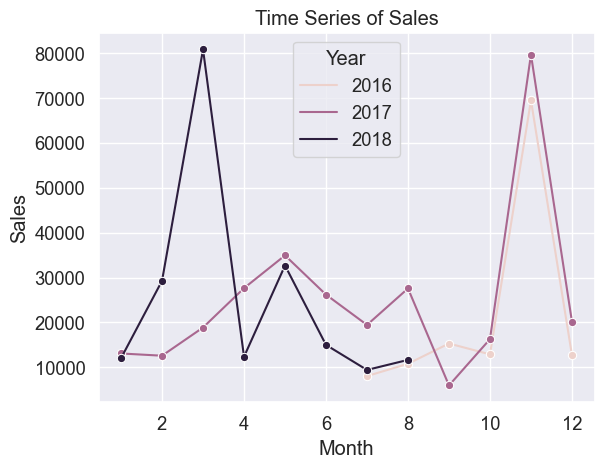

In [8]:
sales_by_month = df.groupby(['year', 'month'])['qty_ordered'].sum().reset_index()

sns.lineplot(data=sales_by_month, x='month', y='qty_ordered', hue='year', marker='o')
plt.title('Time Series of Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend(title='Year')
plt.show()

In [9]:
forecast_horizon = 12
season_length = 12

In [10]:
preprocessor = Preprocessor(
    df=df,
    date_freq = 'MS', # Frequency of the time series, the dataset will be aggregated to this frequency
    date_col='date', # Column with date
    target_col='qty_ordered', # Column to forecast
    id_col=['sku'], # Columns that identify each time series, in this case, we will forecast sales for each product
    category_cols=['category_name', 'sku'], # Categorical columns that do not change over time
    descriptors_cols=['payment_method', 'custumer_id'], # String columns that change over time
    verbose=True,
    multi_category_warning=False # Some products have multiple descriptions
)

c:\Users\Renan.klehm\Documents\Python\true-sight\truesight\preprocessing.py:39: UserWarning: No GPU detected. When using categories, the model will use a half-transformer architecture. This will be slow on CPU.
  warnings.warn(
c:\Users\Renan.klehm\Documents\Python\true-sight\truesight\preprocessing.py:50: UserWarning: No GPU detected. When using descriptors, the model will use a half-transformer architecture. This will be slow on CPU.
  warnings.warn(
100%|██████████| 18003/18003 [00:43<00:00, 409.62it/s]


In [11]:
from statsforecast.models import SeasonalNaive, AutoETS
from sklearn.linear_model import LinearRegression
from truesight.models import AdditiveDecomposition
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"), 
    ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length), 
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AdditiveDecomposition, horizon=forecast_horizon, season_length=season_length)
]

train_dataset, val_dataset = preprocessor.make_dataset(
    forecast_horizon=forecast_horizon,
    train_split=0.8,
    models=models,
    fallback_model=models[0],
    verbose=True,
    nan_warnings=False # When statistical forecasters fail, they return NaN
)

c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
100%|██████████| 3601/3601 [01:46<00:00, 33.79it/s]


In [12]:
train_dataset.save('train_dataset')
val_dataset.save('val_dataset')

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
ts = TrueSight(
    train_dataset, 
    filter_size = 64, 
    n_encoder_layers = 2, 
    n_encoder_heads = 4, 
    context_size = 256, 
    hidden_size = 512, 
    dropout_rate = 0.1
)
ts.compile(optimizer=optimizer, loss='mse')
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3, verbose = False),
]
ts.fit(
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    batch_size = 16, 
    epochs = 50, 
    verbose = True, 
    callbacks = callbacks,
)
ts.plot_training_history()

Epoch 1/50


ValueError: in user code:

    File "c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_filedstx0apm.py", line 58, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(enumerate), (ag__.converted_call(ag__.ld(self).branches.values, (), None, fscope),), None, fscope), None, loop_body, get_state_2, set_state_2, (), {'iterate_names': '(idx, branch)'})
    File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_filedstx0apm.py", line 53, in loop_body
        ag__.if_stmt(ag__.and_(lambda : ag__.ld(self).has_categories, lambda : ag__.ld(idx) == 0), if_body_1, else_body_1, get_state_1, set_state_1, ('temp',), 1)
    File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_filedstx0apm.py", line 52, in else_body_1
        ag__.if_stmt(ag__.and_(lambda : ag__.ld(self).has_descriptors, lambda : ag__.ld(idx) == 1), if_body, else_body, get_state, set_state, ('temp',), 1)
    File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_filedstx0apm.py", line 46, in if_body
        temp = ag__.converted_call(ag__.ld(self).descriptor_encoder, (ag__.ld(temp),), None, fscope)
    File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_filedi2gsek2.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).pos_embedding, (ag__.ld(x),), None, fscope)
    File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_file5odt7z0m.py", line 14, in tf__call
        x = ag__.ld(x) + ag__.ld(self).pos_encoding[ag__.ld(tf).newaxis, :ag__.ld(length), :]

    ValueError: Exception encountered when calling layer "true_sight" "                 f"(type TrueSight).
    
    in user code:
    
        File "c:\Users\Renan.klehm\Documents\Python\true-sight\truesight\core.py", line 91, in call  *
            temp = self.descriptor_encoder(temp)
        File "c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_filedi2gsek2.py", line 10, in tf__call
            x = ag__.converted_call(ag__.ld(self).pos_embedding, (ag__.ld(x),), None, fscope)
        File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_file5odt7z0m.py", line 14, in tf__call
            x = ag__.ld(x) + ag__.ld(self).pos_encoding[ag__.ld(tf).newaxis, :ag__.ld(length), :]
    
        ValueError: Exception encountered when calling layer "descriptor_encoder" "                 f"(type Encoder).
        
        in user code:
        
            File "c:\Users\Renan.klehm\Documents\Python\true-sight\truesight\core.py", line 220, in call  *
                x = self.pos_embedding(x) # type: ignore
            File "c:\Users\Renan.klehm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "C:\Users\RENAN~1.KLE\AppData\Local\Temp\__autograph_generated_file5odt7z0m.py", line 14, in tf__call
                x = ag__.ld(x) + ag__.ld(self).pos_encoding[ag__.ld(tf).newaxis, :ag__.ld(length), :]
        
            ValueError: Exception encountered when calling layer "positional_embedding_1" "                 f"(type PositionalEmbedding).
            
            in user code:
            
                File "c:\Users\Renan.klehm\Documents\Python\true-sight\truesight\layers.py", line 113, in call  *
                    x = x + self.pos_encoding[tf.newaxis, :length, :] # type: ignore
            
                ValueError: Dimensions must be equal, but are 4045 and 2048 for '{{node true_sight/descriptor_encoder/positional_embedding_1/add}} = AddV2[T=DT_FLOAT](true_sight/descriptor_encoder/positional_embedding_1/mul, true_sight/descriptor_encoder/positional_embedding_1/strided_slice_1)' with input shapes: [?,4045,256], [1,2048,256].
            
            
            Call arguments received by layer "positional_embedding_1" "                 f"(type PositionalEmbedding):
              • x=tf.Tensor(shape=(None, 4045), dtype=float32)
        
        
        Call arguments received by layer "descriptor_encoder" "                 f"(type Encoder):
          • x=tf.Tensor(shape=(None, 4045), dtype=float32)
    
    
    Call arguments received by layer "true_sight" "                 f"(type TrueSight):
      • inputs=('tf.Tensor(shape=(None, 32), dtype=float32)', 'tf.Tensor(shape=(None, 4045), dtype=float32)', 'tf.Tensor(shape=(None, 12), dtype=float32)', 'tf.Tensor(shape=(None, 12), dtype=float32)', 'tf.Tensor(shape=(None, 12), dtype=float32)', 'tf.Tensor(shape=(None, 12), dtype=float32)', 'tf.Tensor(shape=(None, 14), dtype=float32)')
